In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
from scipy.optimize import curve_fit





This code to just make the graph of velcor.

In [45]:
c = 'tab:blue' #colour
base_file_name = "23_03_23_E6_PVDRNz"
# Load data from CSV using the first row as column names
df = pd.read_csv(f"F:/Pearson/{base_file_name}_pearson2.csv", header=0)
# Define file paths for output CSV and plot files based on the base file name
column_output_csv = f'F:/pearson/Distance/output/{base_file_name}_distance.csv'
column_output_plot = f'F:/pearson/Distance/plot/{base_file_name}_distance_plot.png'
row_output_csv = f'F:/pearson/Time/output/{base_file_name}_time.csv'
row_output_plot = f'F:/pearson/Time/plot/{base_file_name}_time_plot.png'



# Set the "Time Point" column as the index
df.set_index('Time Point', inplace=True)
# Convert the DataFrame to a NumPy array
data = df.values

# Perform bootstrap analysis for each column
column_bs_results = {}  # Corrected variable name
averages = []  # List to store means
for col_idx in range(0, data.shape[1]):  
    column_data = data[:, col_idx]
    
    # Check if all values in the column are NaN or if there's only 1 non-NaN value
    if np.all(np.isnan(column_data)) or np.sum(~np.isnan(column_data)) <= 1:
        continue  # Skip columns with all NaN values or only 1 non-NaN value

    column_data = column_data[~np.isnan(column_data)]  # Remove any NaN values if present

    # Convert the column data to a two-dimensional NumPy array
    column_data = column_data.reshape(1, -1)

    # Perform bootstrap analysis
    bs_samples = bootstrap(column_data, np.mean, n_resamples=10000, method='percentile', axis=0, confidence_level=0.95)

    # Store the bootstrap results using numeric column indices as keys
    column_bs_results[col_idx] = bs_samples

    # Calculate and store the mean
    averages.append(np.mean(column_data))

# Extract the distance bin headings from the dictionary keys
column_distance_bins = list(column_bs_results.keys())

# Extract the bootstrap confidence intervals from the values
column_confidence_intervals = [result.confidence_interval for result in column_bs_results.values()]

# Create a DataFrame for the confidence intervals
column_ci_df = pd.DataFrame(column_confidence_intervals, columns=['CI_Low', 'CI_High'], index=column_distance_bins)

# Calculate the average value
column_ci_df['Average'] = averages


In [46]:
# Export the column-wise bootstrap results to CSV
column_ci_df.to_csv(column_output_csv)

Exponential Decay Function: y = 0.3337 * exp(-0.2822 * x) + 0.0489


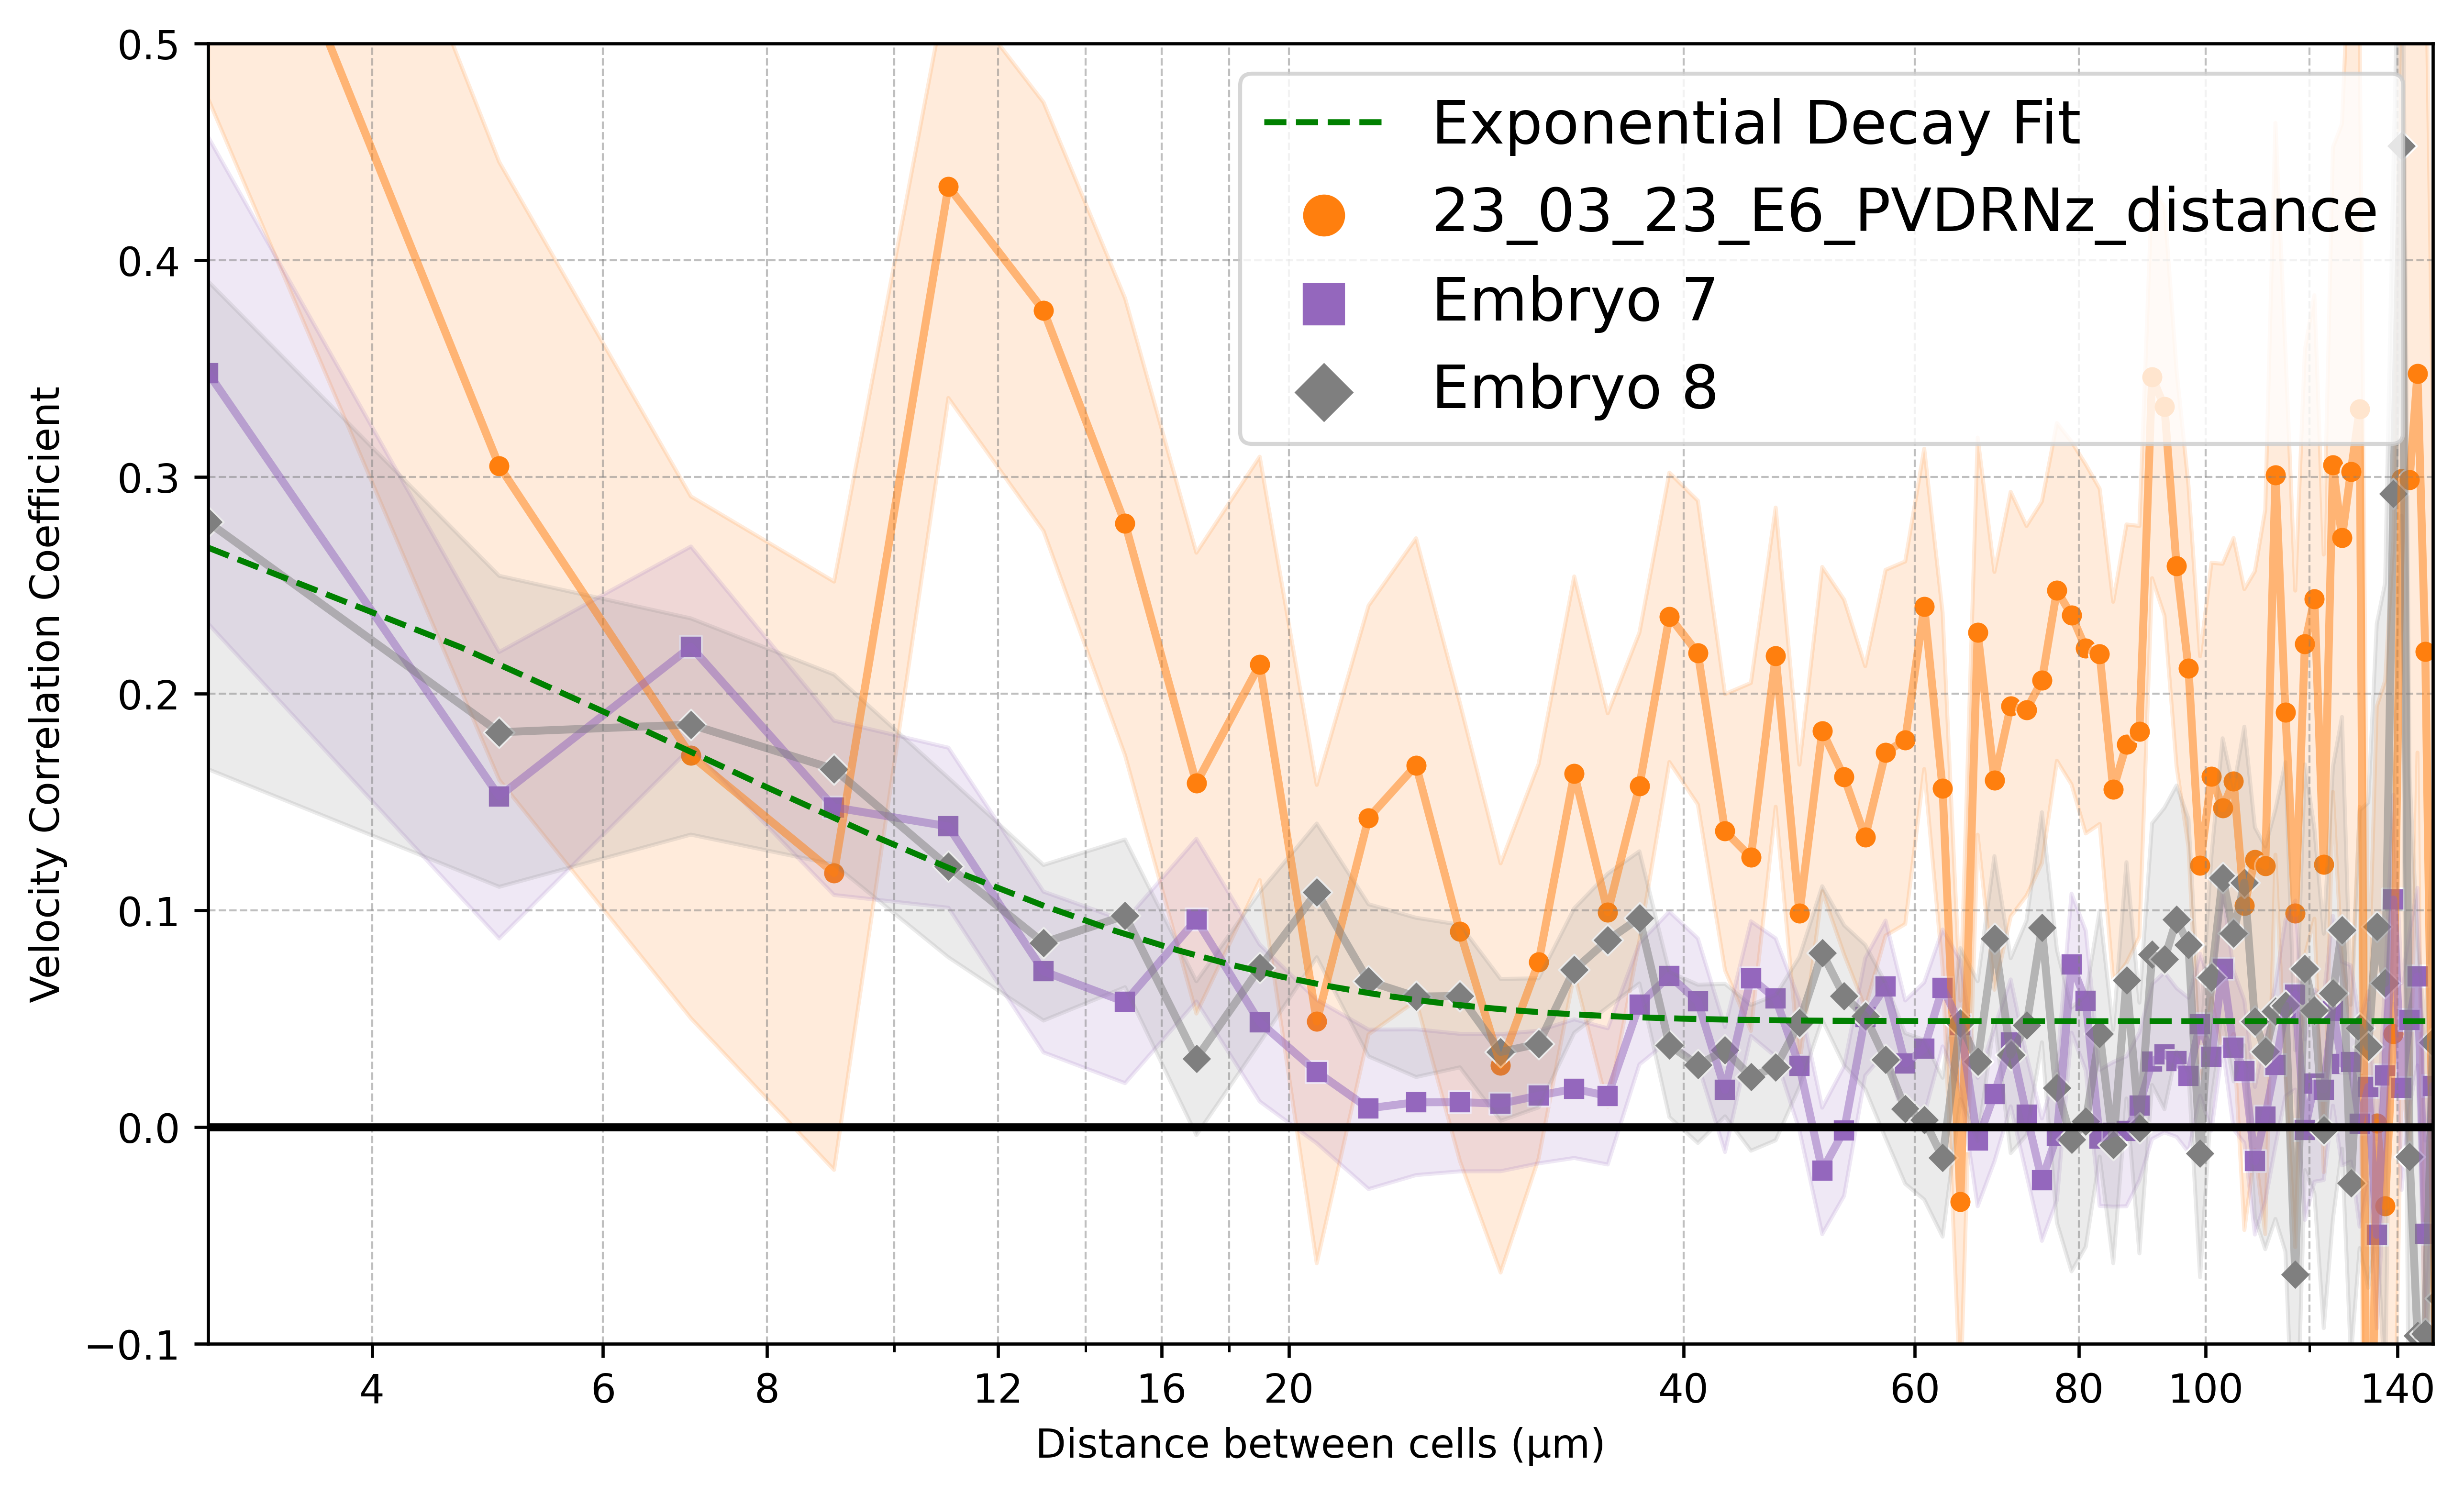

In [3]:
# Define the exponential decay function
def exponential_decay(x, A, B, C):
    return A * np.exp(B * x) + C

# Create a list of DataFrames
df_list = []

# Define a list of marker styles for each series
marker_styles = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']

# Define a shift value to move points half a point to the left
shift_value = 0.5

# Get the list of CSV files in the folder
csv_files = os.listdir('F:/pearson/Distance/output/7to8')

# Iterate over the CSV files
for csv_file in csv_files:
    # Read the data from the CSV file
    df = pd.read_csv(f'F:/pearson/Distance/output/7to8/{csv_file}')

    # Exclude the first row (header) from the DataFrame
    df = df.iloc[1:]
    
    # Reset the index of the DataFrame
    df.reset_index(drop=True, inplace=True)

    # Add the DataFrame to the list
    df_list.append(df)

# Get the file names
file_names = [csv_file[:-4] for csv_file in csv_files]

# Create a custom axes object
fig, ax = plt.subplots(figsize=(10, 6), dpi=600)

# Define the range of data to consider for fitting (3rd row to 75th row)
fit_start_row = 0
fit_end_row = 75

# Iterate over the files
for i, file_name in enumerate(file_names):
    # Check if the columns "Average," "CI_Low," and "CI_High" exist in the DataFrame
    if all(col in df_list[i].columns for col in ["Average", "CI_Low", "CI_High"]):
        # Extract the data for the current experiment
        data = df_list[i]

        # Set the color for the current experiment
        #c = sns.color_palette("tab10")[(3*i)] #Embryos 1to3
        #c = sns.color_palette("tab10")[i+7] #Embryos 4to6
        c = sns.color_palette("tab10")[1+(3*i)] #Embryos 7to8
        #c = sns.color_palette("tab10")[2] #Embryos 1to3
        #c = sns.color_palette("tab10")[i] #Embryos 1,7,9 comparison

        # Set the marker style for the current series
        marker_style = marker_styles[i % len(marker_styles)]

        # Shift the x-values by the shift_value
        shifted_x = data[data.columns[0]] - shift_value

        # Scatter plot with Average and custom marker style
        sns.scatterplot(
            x=shifted_x, # Shifted x-values
            y=data['Average'],
            color=c,
            ax=ax,
            alpha=1,
            s=30, # size of markers
            marker=marker_style,
            label=file_name # Use the file name as a label
        )

        # Error bars using CI_Low and CI_High
        ax.fill_between(
            shifted_x, data['CI_Low'],data['CI_High'], color=c,alpha=0.15 )

        # Add a line to each series
        sns.lineplot(
            x=shifted_x,y=data['Average'], color=c, ax=ax,linewidth=2, alpha=0.5, linestyle='solid' )

# Add a bold horizontal line at y = 0
ax.axhline(0, color='black', linewidth=2)

# Add vertical and horizontal gridlines with custom labels
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xscale('log') # Set x-axis scale to log
ax.set_xlim(2 - shift_value, 75 - shift_value) # Adjust x-axis limits as needed
ax.set_ylim(-0.1, 0.5)

# Set the x-axis tick labels to the values 8, 9, 10, 20, 30, 40, ...
ax.set_xticks(  [2, 3, 4,6, 8,10, 20, 30, 40, 50, 70])
ax.set_xticklabels([4, 6, 8,12, 16,20, 40, 60, 80,100,140]) # Adjust these labels accordingly

# Set the axis titles
ax.set_xlabel("Distance between cells (µm)")
ax.set_ylabel("Velocity Correlation Coefficient")

# Extract the data for fitting the exponential curve within the specified range
fit_data = data.iloc[fit_start_row:fit_end_row]

# Shift the x-values for the fit data
shifted_fit_x = fit_data[fit_data.columns[0]] - shift_value

# Fit the exponential decay curve to your data with adjusted initial guesses
params, covariance = curve_fit(exponential_decay, shifted_fit_x, fit_data['Average'], p0=[10.0, -0.1, 0.1], maxfev=10000)
A, B, C = params # Extract the estimated parameters

# Create a range of x-values for the fitted curve
x_fit = np.linspace(min(shifted_x), max(shifted_x), 100)

# Calculate the corresponding y-values using the fitted parameters
y_fit = exponential_decay(x_fit, A, B, C)

# Plot the fitted exponential decay curve
plt.plot(x_fit, y_fit, label='Exponential Decay Fit', color='g', linestyle='--')

# Print the equation of the fitted exponential decay function
print(f"Exponential Decay Function: y = {A:.4f} * exp({B:.4f} * x) + {C:.4f}")

# Add the proxy artist to the legend
ax.legend(fontsize=15, loc='upper right', markerscale=2)

# Show the plot
plt.show()
